# Motivation

The motivation of BourGAN from the authors is to embed data into a metric space (namely $l_2$) to which we can take advantage of the geometric properties the data may propose and draw vectors provided from a fitted GMM on the metric space. This inturn gives us a more structured latent mapping and helps prevent mode collapse. This paper hinges on Bourgain theory which argues that data can all be transformed onto an $l_2$ space. That is:

For any finite metric space $X$, there exists an embedding of $X$ into a Hilbert space $H$ (a complete inner-product space) such that the distances between points in $X$ are approximately preserved in $H$.

### Libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Data Utility

### Pixel Image Dataset (64 x 64)

We create several thousand images that emulate a gradient decay of Red, Green, Blue, values.

#### Quick Refresher: 2D Guassian Eq. -> Multi-dimensional

The Gaussian func. can be extended to 2D. 

$$
f(x,y) = \dfrac{1}{2\pi\sigma_{x}\sigma_{y}\sqrt{1 - p^2}} \cdot
exp\left(
-\dfrac{1}{2(1 - p^2)} \cdot 
\left[ \dfrac{(x-\mu_x)^2}{\sigma_{x}^2} + \dfrac{(y-\mu_y)^2}{\sigma_{y}^2} - \dfrac{2p(x - \mu_x)(y - \mu_y)}{\sigma_{x} \sigma_{y}} \right]
\right)
$$

* where $\mu_x$ and $\mu_y$ are the means of $x$ and $y$ respectively
* $\sigma_x$ and $\sigma_y$ are the standard deviations of $x$ and $y$ respectively.
* where $p$ is the correlation coefficient between $x$ and $y$

Given a covariance matrix $\Sigma$ for a two dimensional Guassian:
$$
\Sigma = 
\begin{bmatrix}
\sigma_{x}^2 & \sigma_{xy} \\
\sigma_{xy} & \sigma_{y}^2
\end{bmatrix}
$$

Where:

* $\sigma_{x}^2$ is the variance of $x$.
* $\sigma_{y}^2$ is the variance of $y$.
* $\sigma_{xy}$ is the covariance between $x$ and $y$.

The relationship between the correlation coefficient $p$ and the covariance $\sigma_{xy}$ is:

$$
p = \dfrac{\sigma_{xy}}{\sigma_{x}\sigma_{y}}
$$

Thus, using the covariance matrix, we can extend the Gaussian equation to be multi-dimensional:

$$
f(x,y) = \dfrac{1}{2\pi |\Sigma|^{0.5}} \cdot exp \left(
-\dfrac{1}{2} \left[ x - \mu_x y - \mu_y \right] \cdot \Sigma^{-1}
\begin{bmatrix}
x - \mu_{x} \\
y - \mu_{y}
\end{bmatrix}
\right)
$$

** Note $|\Sigma|$ references the determinate

In [48]:
def fill_rgb(fill_val=None, arr=None):
    """
    Fills an 2 dimensional RGB (depth 3) with a fill_val
    O(n^2)
    """
    for row_idx in range(len(arr)):
        for col_idx in range(len(arr[row_idx])):
            arr[row_idx][col_idx] = fill_val
            
    return arr

def determine_bin_edges(data, num_bins=None):
    """
    Determine bin edges based on the given data array.
    """
    if num_bins is None:
        num_bins = int(np.sqrt(len(data)))     # If num_bins is not provided, use the square root rule
    data_min, data_max = np.min(data), np.max(data)
    bin_width = (data_max - data_min) / num_bins
    bin_edges = np.linspace(data_min, data_max, num_bins+1)

    return bin_edges


def multi_dim_inner_term(x, y, mean, covariance_matrix):
    """
    Calculates the multi-dimensional inner term of the Gaussian Eq.
    """
    return (-0.5 * 
            np.dot(np.array([x - mean[0], y - mean[1]]),
                   np.dot(np.linalg.inv(covariance_matrix), np.array([[x - mean[0]], [y - mean[1]]]))
                  )
           )

def transform_pixels_gaussian(image=None, highest_rgb_val=None):
    """
    Fills an 2 Dimensional RGB image that has pixel values that follow a normal distribution, uses multidim-gaus.
    ** Assumes even square image, O(n^2)
    """
    decay_val = 0
    reference_val = highest_rgb_val
    gauss_values = []
    center = int(image.shape[0] / 2)
    mean = [center, center]
    covariance_matrix = [
        [1, 0], 
        [0, 1]
    ] 
    std_devs = np.sqrt(np.diag(covariance_matrix))
    lead_term = (1 / (2 * np.pi * (np.linalg.det(covariance_matrix) ** 0.5)))     # Calculate the lead term for convinience
    # peak_val = lead_term * np.exp(multi_dim_inner_term(mean[0], mean[1], mean, covariance_matrix))
    
    for row_idx in range(len(image)):
        for col_idx in range(len(image[row_idx])):
            x = row_idx + 1
            y = col_idx + 1
            inner_exp = multi_dim_inner_term(x, y, mean, covariance_matrix)
            exp_term = np.exp(inner_exp)
            gauss_output = lead_term * exp_term
            gauss_values.append(gauss_output[0])
    
    bin_edges = determine_bin_edges(gauss_values, 100)
    bin_indices = np.digitize(gauss_values, bin_edges)
    
    transformed_arr =  np.repeat(np.array(bin_indices), 3).reshape(image.shape[0], image.shape[0], 3)
    unique_nums, unique_counts = np.unique(transformed_arr, return_counts=True)
    
    for num in reversed(unique_nums): # Assume the first num has the most value
        num_arr = [num, num, num] # Assume RGB
        mask = np.all(transformed_arr == num_arr, axis=-1)
        reference_val = np.array(reference_val) / 1.1
        transformed_arr[mask] = np.array(
            (reference_val) 
        )
        
    return transformed_arr
            

In [70]:
_template = np.empty([64, 64, 3], dtype=int)

red_image = transform_pixels_gaussian(_template ,[255, 0, 0])
green_image = transform_pixels_gaussian(_template ,[0, 255, 0])
blue_image = transform_pixels_gaussian(_template ,[0, 0, 255])

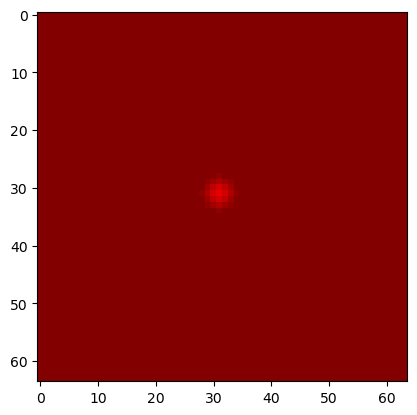

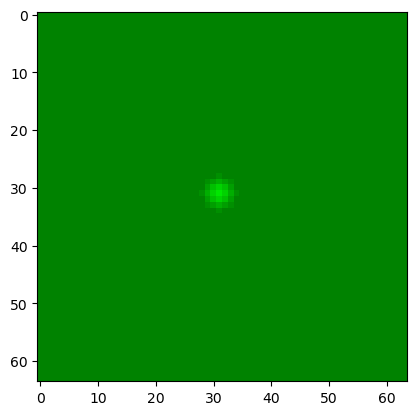

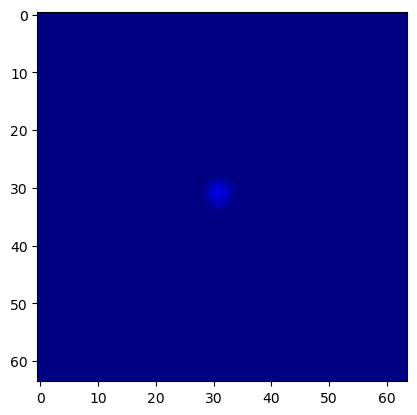

In [71]:
plt.imshow(red_image)
plt.show()
plt.imshow(green_image)
plt.show()
plt.imshow(blue_image)
plt.show()

#### Adding some random noise to images

In [78]:
def add_noise(image=None, rgb_val = None, n_times=None):
    """
    Adds noise based on the position of the highest RGB value
    """
    max_idx = np.argmax(rgb_val)
    output_image = np.copy(image)
    
    for n in range(n_times):
        rgb_val[max_idx] = np.random.randint(255) # 0-255 Val
        rand_row = np.random.randint(output_image.shape[0] - 1)
        rand_col = np.random.randint(output_image.shape[0] - 1)
        output_image[rand_row][rand_col] = rgb_val
    
    return output_image

def image_harness(
    template_image = None, 
    rgb_val = None, 
    n_samples = None
):
    """
    Applies functions onto an image and appends the result in an array to be returned
    """
    res = [];
    for n in range(n_samples):
        img = add_noise(template_image, rgb_val, 100)
        res.append(img)
        
    return np.array(res)
    

#### Create our Dataset

In [85]:
red_images = image_harness(red_image, [255, 0, 0], 1000)
green_images = image_harness(green_image, [0, 255, 0], 1000)
blue_images = image_harness(blue_image, [0, 0, 255], 1000)

In [88]:
X_Data = np.concatenate((red_images, green_images, blue_images))
X_Data.shape

(3000, 64, 64, 3)

# Images -> Hilbert Space: Bourgain Theorem

#### Bourgain Theorem
Recall that Bourgain's Theorem about metric embeddings follows:

For every finite metric space, $X$, and every $\epsilon > 0$, **there exists** an embedding such that $f: X \rightarrow L^2$ (transformed onto a Hilbert Space) such that for all $x, y \in X$.

$$
(1 - \epsilon)d(x, y)^2 \leq || f(x) - f(y) ||^2 \leq (1 + \epsilon) d(x,y)^2
$$

Where:
* $d$ is a metric on $X$
* $|| \cdot ||$ is the $L^2$ norm

#### Metric Spaces

A metric space is defined by a set, together with a function called a metric (often denoted as $d$) that assigns a **non-negative real number** to each pair of elements in the set. This metric satisfies certain properties:

* **Non-negativity**: $d(x,y) \geq 0$ for all $x$,$y$, with equality if and only if $x=y$ - If $x$ and $y$ are ontop of each other (in a way). Then have no distance between them.
* **Symmetry**: $d(x,y)=d(y,x)$ for all $x$,$y$ - Order doesn't matter on how you measure them
* **Triangle Inequality**: $d(x,y) + d(y,z) \geq d(x,z)$ for all $x,y,z$ 

In the Bourgain paper, they formally describe that for a Metric space:

**Metric space** . A metric space is described by a pair $(M, d)$, where $M$ is a set and $d: M×M → R \geq 0$ is a distance function such that $∀x, y, z ∈ M$, we have:
* $d(x, y) = 0 ⇔ x = y$ 

* $d(x, y) = d(y, x)$

* $d(x, z) ≤ d(x, y) + d(y, z)$ 

If $M$ is a finite set, then we call $(M, d)$ a finite metric space.

#### Posing the data

The authors of the paper mention that provided with a multiset of data items denoted as:

$$
X = \{x_i\}^n_{i = 1}
$$

drawn independently from an unknown distribution $X$. They subsample $m(m < n)$ data uniformly from $X$. They denote this new multiset of data items subsampled as $Y$ where:

$$
Y \subseteq X 
\\
|Y| = m
$$

Where elements of $Y$ are embedded in $l_2$ space.

# Distances

### L2 Distance (Euclidean Distance)

In [93]:
def calculate_l2_dist(img_1=None, img_2=None):
    """
    Euclidean distance is the l2 norm. There is the connection of the norm 
    (in this case the Frobenius norm/2-norm which is the default for norm function) 
    the Euclidean distance.
    """
    return np.linalg.norm(img_1-img_2)

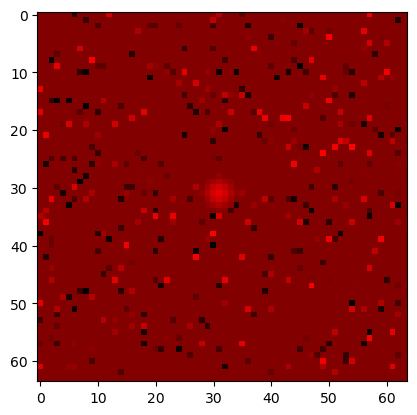

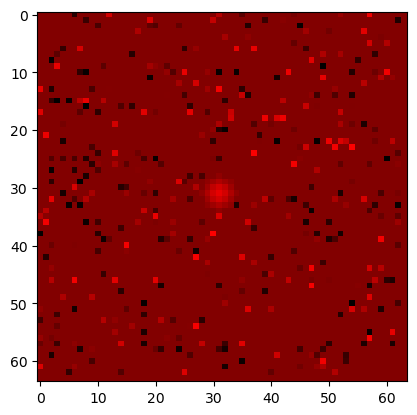

Distance is: 1109.7242900829017


In [95]:
plt.imshow(red_images[0])
plt.show()
plt.imshow(red_images[1])
plt.show()

print("Distance is:", calculate_l2_dist(red_images[0], red_images[1]))

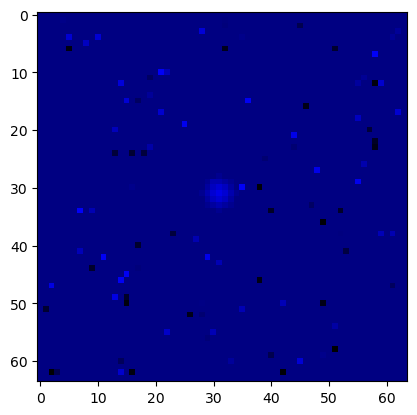

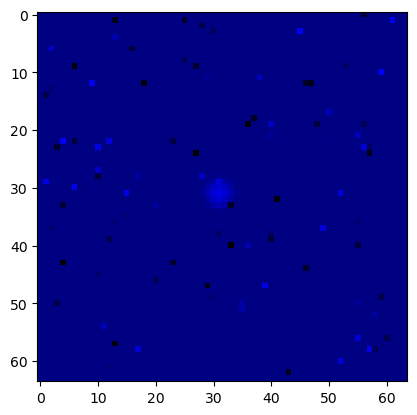

Distance is: 1064.3331245432512


In [100]:
plt.imshow(blue_images[0])
plt.show()
plt.imshow(blue_images[1])
plt.show()

print("Distance is:", calculate_l2_dist(blue_images[0], blue_images[1]))

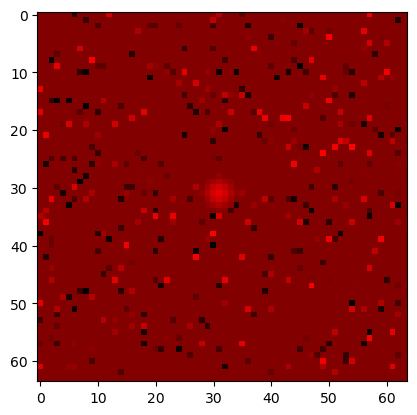

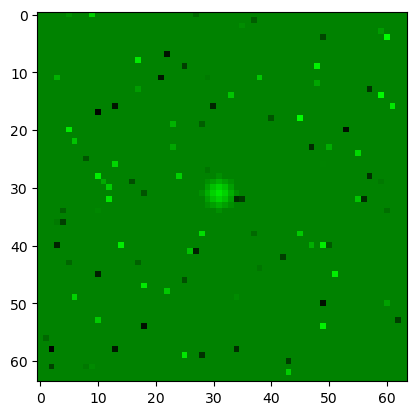

Distance is: 11862.04497546692


In [99]:
plt.imshow(red_images[0])
plt.show()
plt.imshow(green_images[1])
plt.show()

print("Distance is:", calculate_l2_dist(red_images[0], green_images[1]))

### Wassertstein-1 distance (EMD) as d(x,y)
Let us take a quick look of EMD distance between images so that we can later use this as our distance function for our metric embedding.

As the authors note:

Wasserstein-1 distance, also known as the Earth-Mover distance, is one of the distance measures to quantify the similarity of two distributions, defined as:

$$
W(P_a,P_b) = \inf_{Γ∈Π(P_a,P_b)} E(x,y)∼Γ (|x−y|)
$$

where $P_a$ and $P_b$ are two distributions on real numbers, and $Π(Pa, Pb)$ is the set of all joint distributions $Γ(x, y)$ on two real numbers whose marginal distributions are $P_a$ and $P_b$, respectively.

# Embedding (Bourgain's Theorem)

#### Creation of a Random Subset